## Update

6/19
* used median_filter before get_centroid --> quite slow
* hot pixels still seen in PI
* better manually shift the images

In [2]:
from datetime import datetime as dt

dt.now()

datetime.datetime(2017, 6, 24, 19, 0, 55, 931211)

This is modified version of *_all_realigned using photutils.find_peaks for better realignment 

In [3]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [4]:
import os
os.environ['CONDA_DEFAULT_ENV']

'iraf27'

In [5]:
import glob
import getpass
import os
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf


from astropy.visualization import ZScaleInterval
interval= ZScaleInterval()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nframes = 3
wpangle=4
ndither=5

skysub_ch1 = glob.glob('*fgs_ch1.fits')
skysub_ch1.sort()
skysub_ch2 = glob.glob('*fgs_ch2.fits')
skysub_ch2.sort()

## Check sky-subtracted frames

Sky subtraction was done as follows:
* dither 1 - dither 2
* dither 2 - dither 1
* dither 3 - dither 2
* dither 4 - dither 3
* dither 5 - dither 4

## 3 waveplate rotation sets

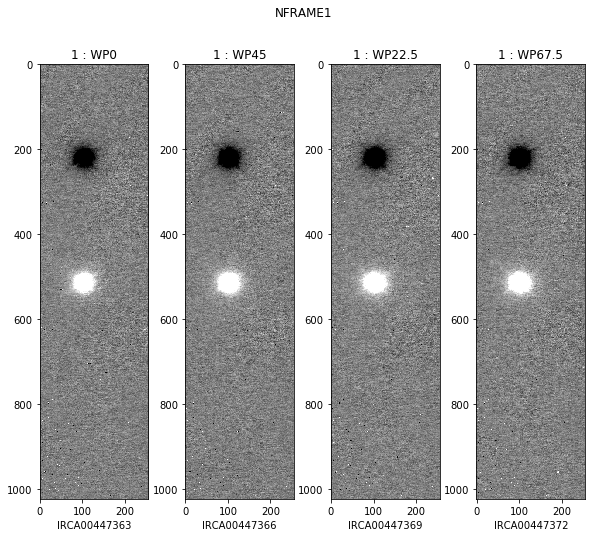

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,8))
idx=0
nframes=3
wpangle=4

#dither 1
for i in skysub_ch1[:nframes*wpangle][::nframes]:
    hdr = pf.getheader(i) #[i+1] for nframe2
    img = pf.getdata(i) #[i+1] for nframe2
    vmin, vmax = interval.get_limits(img)
    ax[idx].imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
    plt.suptitle('NFRAME1')
    if isinstance(hdr['I_DTHPOS'], str): 
        ax[idx].set_title(hdr['I_DTHPOS'])
        ax[idx].set_xlabel(hdr['FRAMEID'])
    else:
        pass
    idx+=1

## combine I images (dither 1) after shift ch1 8.2 pixels to the right 

In [7]:
from scipy.ndimage.interpolation import shift

I = {}

for i in range(len(skysub_ch1)):
    hdr = pf.getheader(skysub_ch1[i])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i])
    #shift x=8.2 pix
    img1_shifted = shift(img1, shift=(0,8.2), mode='wrap')
    img2 = pf.getdata(skysub_ch2[i])
    I[i] = img1_shifted + img2
    #print(hdr)

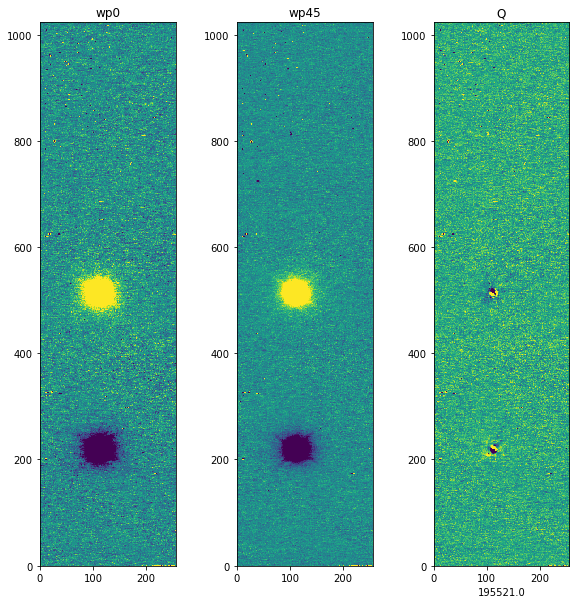

In [8]:
from scipy.ndimage.interpolation import shift

fig,ax = plt.subplots(1,3,figsize=(10,10))
vmin1,vmax1=interval.get_limits(I[0])
ax[0].imshow(I[0],vmin=vmin,vmax=vmax, origin='lower')
ax[0].set_title('wp0')

vmin2,vmax2=interval.get_limits(I[1])
ax[1].imshow(I[1],vmin=vmin2,vmax=vmax2, origin='lower')
ax[1].set_title('wp45')

diff=I[0]-I[1]
vmin3,vmax3=interval.get_limits(diff)
ax[2].imshow(diff,vmin=vmin3,vmax=vmax3, origin='lower')
ax[2].set_title('Q')
ax[2].set_xlabel(np.linalg.norm(diff, ord=2))

In [9]:
from scipy.ndimage.interpolation import shift

#I.keys()
#split I into each nframe: 20 I image each dict
I1 = {}
I2 = {}
I3 = {}

#nframe1
for m,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr1 = pf.getheader(skysub_ch1[i])['I_DTHPOS']
    #ch1
    img1 = pf.getdata(skysub_ch1[i])
    img1_shifted = shift(img1, shift=(0,8.2), mode='wrap')
    #ch2
    img2 = pf.getdata(skysub_ch2[i])
    I1[m] = img1_shifted + img2

#nframe2
for n,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr2 = pf.getheader(skysub_ch1[i+1])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i+1])
    img1_shifted = shift(img1, shift=(0,8.2), mode='wrap')
    img2 = pf.getdata(skysub_ch2[i+1])
    I2[n] = img1_shifted + img2
    
#nframe3
for o,i in enumerate(range(len(skysub_ch1))[::3]):
    hdr1 = pf.getheader(skysub_ch1[i+2])['I_DTHPOS']
    img1 = pf.getdata(skysub_ch1[i+2])
    img1_shifted = shift(img1, shift=(0,8.2), mode='wrap')
    img2 = pf.getdata(skysub_ch2[i+2])
    I3[o] = img1_shifted + img2
    
I1.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

## check alignment of I

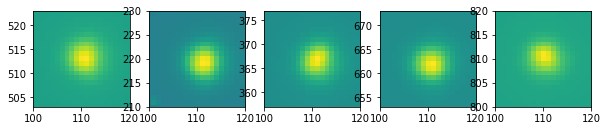

In [10]:
fig, ax = plt.subplots(1,5,figsize=(10,10))

xest = (100,120)
yest = [(503,523), (210,230), (357,377), (653,673), (800,820)]
#nframe 1
for i,j in enumerate(I1.keys()[::wpangle]): #only first set of dither
    ax[i].imshow(I1[j])
    ax[i].set_xlim(xest)
    ax[i].set_ylim(yest[i])

(100, 120)

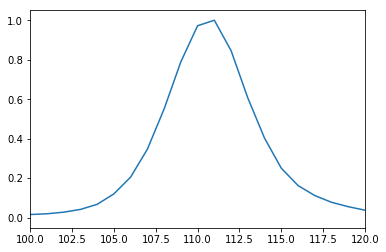

In [11]:
xslice=513
plt.plot(I1[0][xslice,:]/np.max(I1[0][xslice,:]))
plt.xlim(100,120)

estimated fwhm=10 pix

## estimate initial centroid of each dither 

In [12]:
fwhm_estimate=10
sigma=fwhm_estimate / (2*np.sqrt(2*np.log(2)))
sigma

4.2466090014400955

In [13]:
convolve=False

from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from scipy.ndimage.filters import gaussian_filter


def get_centroid(img, num_stars=1, fwhm=10.0):
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)
    if convolve==True:
        #apply median filter to remove hot pixels
        img = gaussian_filter(img, sigma=sigma, mode='nearest')#,cval=0
    sources = daofind(img - median)
    #get index of brightest source
    idx = [i for i,j in enumerate(sources['peak']) if j == max(sources['peak'])]
    #get peak
    x_max, y_max = float(sources['xcentroid'][idx].data), float(sources['ycentroid'][idx].data)
    
    return (x_max, y_max)

In [14]:
from tqdm import tqdm

centroidsI1,centroidsI2,centroidsI3 =[],[],[]
for key in tqdm(I1.keys()):
    centroidsI1.append(get_centroid(I1[key]))
for key in tqdm(I2.keys()):
    centroidsI2.append(get_centroid(I2[key]))
for key in tqdm(I3.keys()):
    centroidsI3.append(get_centroid(I3[key]))

centroidsI1

100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


[(110.78886476204818, 513.1509679214682),
 (110.8737307671139, 513.4617239354258),
 (110.69822450864004, 513.451679785669),
 (110.76483740481041, 513.3510531995545),
 (111.39659436619374, 219.2470583413488),
 (111.47119097795748, 219.79138650576422),
 (111.5798500019414, 219.9899870856633),
 (111.73311297689749, 220.07925913391063),
 (111.11630989668834, 366.56292234945806),
 (111.11608289771932, 366.5600744674348),
 (110.77821968533242, 366.6876006916204),
 (111.14481585339085, 366.73002234788925),
 (110.66754345691247, 661.9026960879646),
 (110.48118563111713, 662.153881644203),
 (110.65367878038293, 662.2005420301549),
 (110.53829368199335, 662.5697827940631),
 (110.27797530763674, 810.1771840340326),
 (109.9105497300116, 810.0742728518926),
 (110.10524922020205, 810.2389039267217),
 (110.12621342791243, 810.0306830597503)]

In [15]:
#dither1
np.array(centroidsI1[:4])

array([[ 110.78886476,  513.15096792],
       [ 110.87373077,  513.46172394],
       [ 110.69822451,  513.45167979],
       [ 110.7648374 ,  513.3510532 ]])

## check centroid estimates

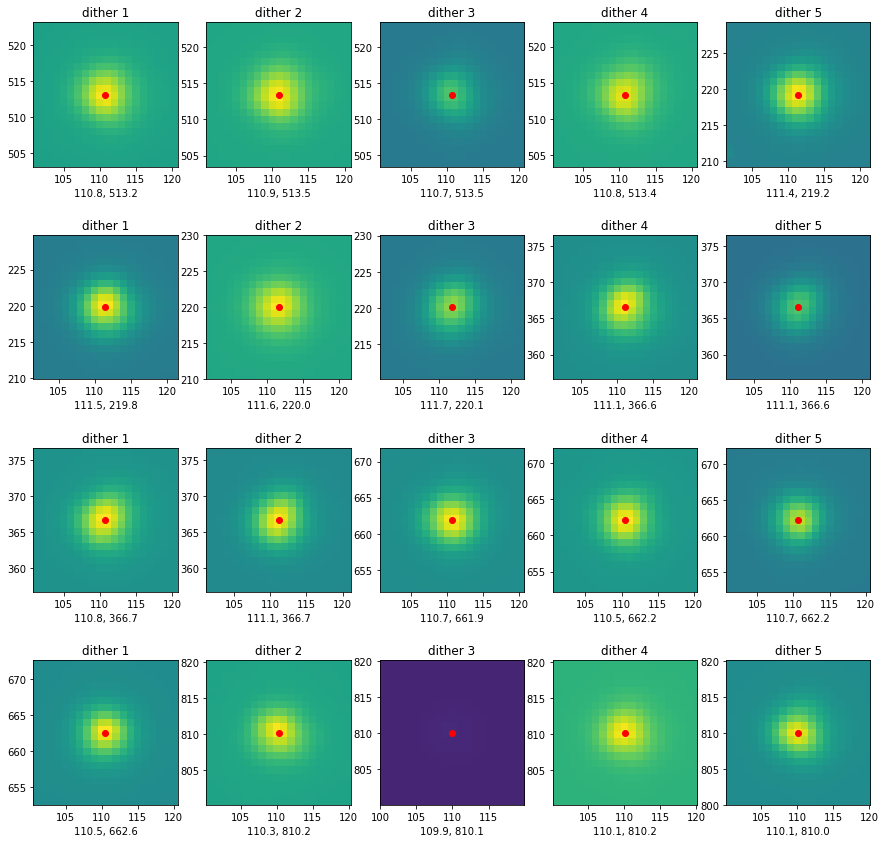

In [16]:
fig = plt.figure(figsize=(15,15))

dither_x = [row[0] for row in centroidsI1]
dither_y = [row[1] for row in centroidsI1]

n=10
#nframe 1
for i,j in enumerate(I1.keys()):
    ax = plt.subplot(4,5,i+1)
    #vmin, vmax = interval.get_limits(I1[j])
    ax.imshow(I1[j])#,vmin=vmin,vmax=vmax)
    ax.set_xlim([dither_x[i]-n,dither_x[i]+n])
    ax.set_ylim([dither_y[i]-n,dither_y[i]+n])
    ax.plot(dither_x[i],dither_y[i],'ro', linewidth='10')
    ax.set_title('dither {}'.format(i%5+1))
    ax.set_xlabel('{0:.1f}, {1:.1f}'.format(dither_x[i],dither_y[i]))

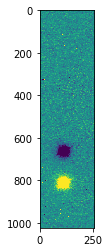

In [17]:
#check what's wrong with I[17]
vmin, vmax = interval.get_limits(I1[17])
plt.imshow(I1[17], vmin=vmin,vmax=vmax)

centroids are more accurate when convolve=False

In [18]:
def get_crop(image, centroid, box_size):
    '''
    simple cropping tool
    '''
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])
    return image_crop

In [19]:
#I was already shifted above before combining ch1 and ch2 into I,
#but I'll stick with I1_shifted after cropping image in all nframes

I1_shifted = {}
I2_shifted = {}
I3_shifted = {}

for key in I1.keys():
    #instead of shifting, crop at centroid
    I1_shifted[key] = get_crop(I1[key], centroidsI1[key], box_size=200)

for key in I2.keys():
    #instead of shifting, crop at centroid
    I2_shifted[key] = get_crop(I2[key], centroidsI2[key], box_size=200)
    
for key in I3.keys():
    #instead of shifting, crop at centroid
    I3_shifted[key] = get_crop(I3[key], centroidsI3[key], box_size=200)

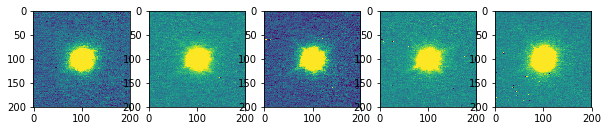

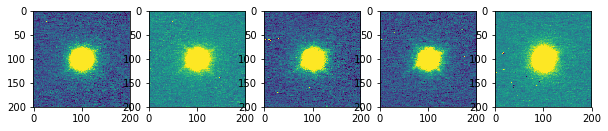

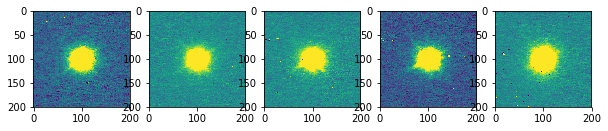

In [22]:
fig, ax = plt.subplots(1,5,figsize=(10,10))
#nframe 1
for i,key in enumerate(list(I1.keys()[::4])): #only first set
    vmin, vmax = interval.get_limits(I1_shifted[key])
    ax[i].imshow(I1_shifted[key], vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1,5,figsize=(10,10))
#nframe 2
for i,key in enumerate(list(I2.keys()[::4])): #only first set
    vmin, vmax = interval.get_limits(I2_shifted[key])
    ax[i].imshow(I2_shifted[key], vmin=vmin, vmax=vmax)
    
fig, ax = plt.subplots(1,5,figsize=(10,10))
#nframe 3
for i,key in enumerate(list(I3.keys()[::4])): #only first set
    vmin, vmax = interval.get_limits(I3_shifted[key])
    ax[i].imshow(I3_shifted[key], vmin=vmin, vmax=vmax)

sum every first four image (=one WP cycle) in each I1, I2, I3 (i.e. nframe 1,2,3) to get Itot per dither.

## Combine aligned I image (I_shifted) per WP cycle: Itot

In [23]:
Itot1={} #nframe1 with 5 dithered images
Itot2={}
Itot3={}

#nframe 1: dither 1 to 5
for i,j in enumerate(I1_shifted.keys()[::4]):
    Itot1[i]=[]
    Itot1[i].append(I1_shifted[j])
    print(i,j)
    Itot1[i].append(I1_shifted[j+1])
    print(i,j+1)
    Itot1[i].append(I1_shifted[j+2])
    print(i,j+2)
    Itot1[i].append(I1_shifted[j+3])
    print(i,j+3)
    
#nframe 2: dither 1 to 5
for i,j in enumerate(I2_shifted.keys()[::4]): 
    Itot2[i]=[]
    Itot2[i].append(I2_shifted[j])
    Itot2[i].append(I2_shifted[j+1])
    Itot2[i].append(I2_shifted[j+2])
    Itot2[i].append(I2_shifted[j+3])
    
#nframe 3: dither 1 to 5
for i,j in enumerate(I3_shifted.keys()[::4]):
    Itot3[i]=[]
    Itot3[i].append(I3_shifted[j])
    Itot3[i].append(I3_shifted[j+1])
    Itot3[i].append(I3_shifted[j+2])
    Itot3[i].append(I3_shifted[j+3])

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(4, 16)
(4, 17)
(4, 18)
(4, 19)


In [24]:
np.array(Itot1[0]).shape

(4, 200, 200)

In [25]:
for i in Itot1.keys():
    Itot1[i]=np.median(Itot1[i],axis=0)
    Itot2[i]=np.median(Itot2[i],axis=0)
    Itot3[i]=np.median(Itot3[i],axis=0)

after stacking,

In [26]:
np.array(Itot1[0]).shape

(200, 200)

In [27]:
Itot1.keys()

[0, 1, 2, 3, 4]

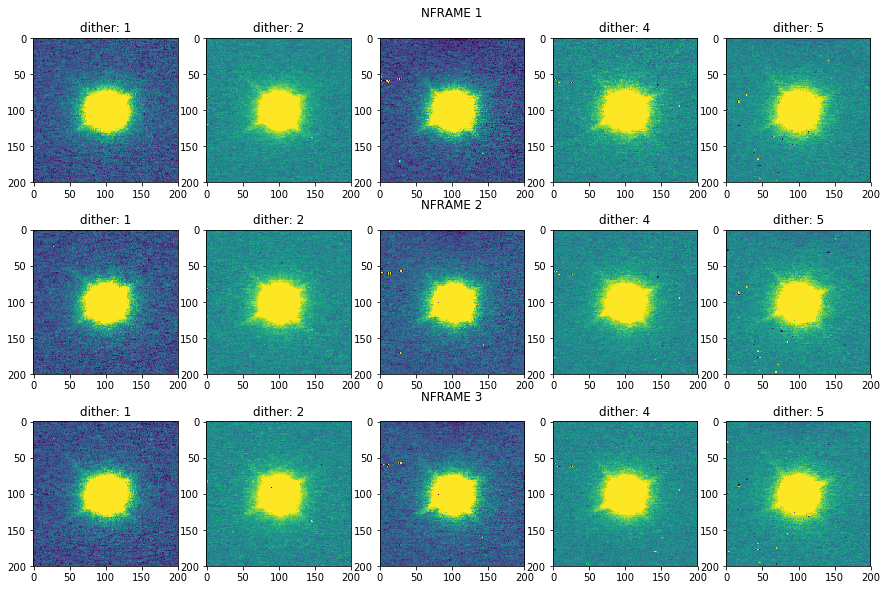

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for n,key in enumerate(Itot1.keys()):
    vmin1, vmax1 = interval.get_limits(Itot1[key])
    vmin2, vmax2 = interval.get_limits(Itot2[key])
    vmin3, vmax3 = interval.get_limits(Itot2[key])
    
    #Itot1: nframe1
    ax[0,n].imshow(Itot1[key], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Itot2: nframe2
    ax[1,n].imshow(Itot2[key], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Itot3 nframe3
    ax[2,n].imshow(Itot3[key], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

proper subplotting [here](https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot)

In [31]:
#sample for nframe3
for i in range(len(skysub_ch1))[::3]:
    hdr = pf.getheader(skysub_ch1[i+2])['I_DTHPOS']
    print(hdr)

1 : WP0
1 : WP45
1 : WP22.5
1 : WP67.5
2 : WP0
2 : WP45
2 : WP22.5
2 : WP67.5
3 : WP0
3 : WP45
3 : WP22.5
3 : WP67.5
4 : WP0
4 : WP45
4 : WP22.5
4 : WP67.5
5 : WP0
5 : WP45
5 : WP22.5
5 : WP67.5


As seen above, consecutive frames must be subtracted to get Q and U. The 20 I images per nframe will be split into 5 Q and 5 U images.

In [32]:
Q1 = {}
Q2 = {}
Q3 = {}
U1 = {}
U2 = {}
U3 = {}

#nframe 1
for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    Q1[h]=I1_shifted[i]-I1_shifted[i+1]
    #5 U images each nframe
    print(i+2,i+3)
    U1[h]=I1_shifted[i+2]-I1_shifted[i+3]
    
#nframe 2
for h,j in enumerate(range(len(I2_shifted))[::4]):
    Q2[h]=I2_shifted[j]-I2_shifted[j+1]
    U2[h]=I2_shifted[j+2]-I2_shifted[j+3]
    
#nframe 3
for h,k in enumerate(range(len(I3))[::4]):
    Q3[h]=I3_shifted[k]-I3_shifted[k+1]
    U3[h]=I3_shifted[k+2]-I3_shifted[k+3]
    

(0, 1)
(2, 3)
(4, 5)
(6, 7)
(8, 9)
(10, 11)
(12, 13)
(14, 15)
(16, 17)
(18, 19)


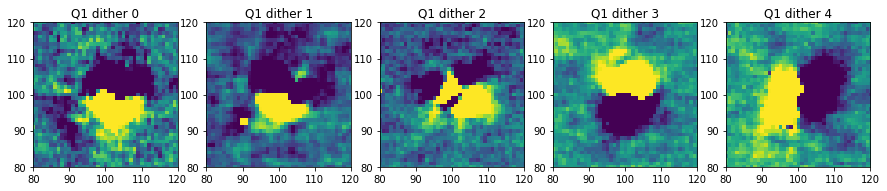

In [33]:
fig, ax = plt.subplots(1,5,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j], vmin=vmin, vmax=vmax, cmap='viridis')
    ax[i].set_title('Q1 dither {}'.format(i+1))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

shift o image (left) to the right by 8 pixels like what was done in realigning I images

## realigning Q and U

## using cross-correlation shifts

In [34]:
import image_registration as im_reg
from scipy.ndimage.interpolation import shift

Q1_shifted = {}
Q2_shifted = {}
Q3_shifted = {}
U1_shifted = {}
U2_shifted = {}
U3_shifted = {}

for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    wp0=I1_shifted[i]
    wp45=I1_shifted[i+1]
    dy, dx = im_reg.cross_correlation_shifts(wp0, wp45, maxoff=4, return_error=False, zeromean=True)
    print('dy={0:.2f}, dx={1:.2f}'.format(dy, dx))
    #aligned_ch3 = np.roll(np.roll(im3,int(yoff),1),int(xoff),0) #shift based on calculated centroid
    shifted = shift(wp0, shift=(dy, dx))
    Q1_shifted[h]=I1_shifted[i+1] - shifted

(0, 1)
dy=0.10, dx=0.30
(4, 5)
dy=0.08, dx=0.52
(8, 9)
dy=0.00, dx=-0.02
(12, 13)
dy=-0.75, dx=-0.85
(16, 17)
dy=0.61, dx=-0.17


subpixel shifts does not minimize residual as shown on the bottom

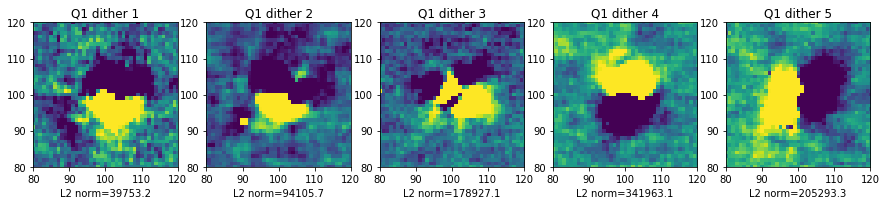

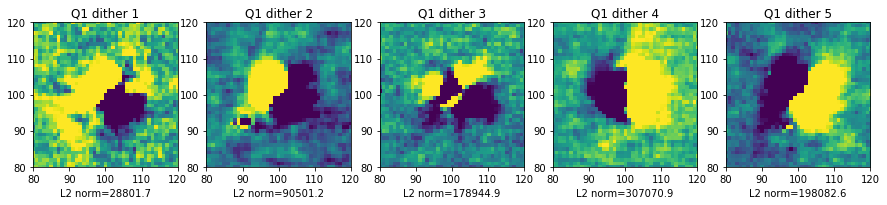

In [37]:

fig, ax = plt.subplots(1,5,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i+1))
    ax[i].set_xlabel('L2 norm={:.1f}'.format(np.linalg.norm(Q1[j], ord=2)))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,5,figsize=(15,10))
for i,j in enumerate(Q1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i+1))
    ax[i].set_xlabel('L2 norm={:.1f}'.format(np.linalg.norm(Q1_shifted[j], ord=2)))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

### random shifting to produce smallest residuals

In [38]:
from numpy.linalg import norm

def minimize_residual_std(img1, img2):
    residuals = {}
    diff = {}
    dx=dy=np.arange(-3,3,0.5)
    for i in dx:
        for j in dy:
            img2_shifted = shift(img2, shift=(j, i))
            diff[str(i)+','+str(j)] = img1 - img2_shifted
            residuals[str(i)+','+str(j)] = norm(img1 - img2_shifted, ord=2) #np.abs() does not work; np.std()
    #get smallest flux
    min_flux = np.min([residuals[k] for k in residuals.keys()])
    #get indices of shifts with minimum flux (dy,dx)
    idx = [k for k in residuals.keys() if residuals[k] == min_flux]
    #get image with smallest residual
    img = diff[idx[0]]
    return (img, idx[0].split(',')) #dict of images


#wp0 and wp45
img1=I1_shifted[0]
img2=I1_shifted[1]

(img, shift_xy) = minimize_residual_std(img1, img2)

In [39]:
Q1_shifted = {}
Q2_shifted = {}
Q3_shifted = {}
U1_shifted = {}
U2_shifted = {}
U3_shifted = {}

#nframe1
for h,i in enumerate(range(len(I1_shifted))[::4]):
    #5 Q images each nframe
    print(i,i+1)
    wp0=I1_shifted[i]
    wp45=I1_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual_std(wp0, wp45)
    print('dx,dy={}'.format(Qshift_xy))
    Q1_shifted[h]= Qimg
    #shift to make U
    print(i+2,i+3)
    wp225=I1_shifted[i+2]
    wp675=I1_shifted[i+3]
    '''
    #U must be shifted independently from Q
    dx, dy = shift_xy[0], shift_xy[1]
    wp675_shifted = shift(wp675, shift=(int(dy), int(dx)))
    U1_shifted[h]= wp225 - wp675_shifted '''
    (Uimg, Ushift_xy) = minimize_residual_std(wp225, wp675)
    print('dx,dy={}'.format(Ushift_xy))
    U1_shifted[h]= Uimg

#nframe2
for h,i in tqdm(enumerate(range(len(I2_shifted))[::4])):
    #print(i,i+1)
    wp0=I2_shifted[i]
    wp45=I2_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual_std(wp0, wp45)
    #print('dx,dy={}'.format(Qshift_xy))
    Q2_shifted[h]= Qimg
    #shift to make U
    #print(i+2,i+3)
    wp225=I2_shifted[i+2]
    wp675=I2_shifted[i+3]
    (Uimg, Ushift_xy) = minimize_residual_std(wp225, wp675)
    #print('dx,dy={}'.format(Ushift_xy))
    U2_shifted[h]= Uimg
    
#nframe3
for h,i in tqdm(enumerate(range(len(I3_shifted))[::4])):
    #print(i,i+1)
    wp0=I3_shifted[i]
    wp45=I3_shifted[i+1]
    (Qimg, Qshift_xy) = minimize_residual_std(wp0, wp45)
    #print('dx,dy={}'.format(Qshift_xy))
    Q3_shifted[h]= Qimg
    #shift to make U
    #print(i+2,i+3)
    wp225=I3_shifted[i+2]
    wp675=I3_shifted[i+3]
    (Uimg, Ushift_xy) = minimize_residual_std(wp225, wp675)
    #print('dx,dy={}'.format(Ushift_xy))
    U3_shifted[h]= Uimg
    
print('---DONE---')

(0, 1)
dx,dy=['0.0', '-0.5']
(2, 3)
dx,dy=['0.0', '0.0']
(4, 5)
dx,dy=['0.0', '-0.5']
(6, 7)
dx,dy=['-0.5', '0.5']
(8, 9)
dx,dy=['0.5', '0.5']
(10, 11)
dx,dy=['0.5', '0.0']
(12, 13)
dx,dy=['-1.0', '-0.5']
(14, 15)
dx,dy=['0.0', '-0.5']
(16, 17)
dx,dy=['-1.0', '0.0']
(18, 19)


0it [00:00, ?it/s]

dx,dy=['0.0', '0.0']


5it [00:15,  3.07s/it]
5it [00:14,  2.94s/it]

---DONE---


## Manual shifts

shifted Q comparison

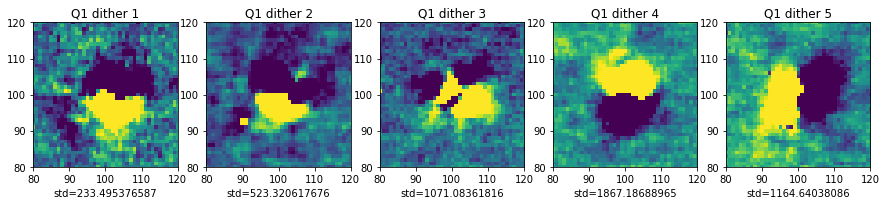

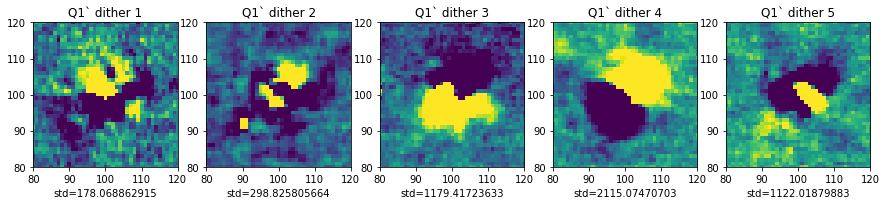

In [40]:
fig, ax = plt.subplots(1,5,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(Q1.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1 dither {}'.format(i+1))
    #ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlabel('std={}'.format(np.std(Q1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,5,figsize=(15,10))
for i,j in enumerate(Q1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(Q1[j])
    ax[i].imshow(Q1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('Q1` dither {}'.format(i+1))
    ax[i].set_xlabel('std={}'.format(np.std(Q1_shifted[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

shifted U comparison

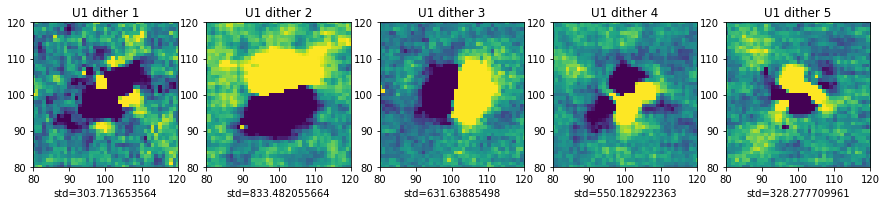

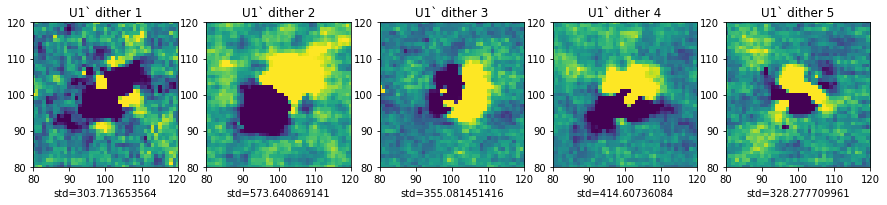

In [41]:
fig, ax = plt.subplots(1,5,figsize=(15,10))

#nframe 1
n=100
m=20
for i,j in enumerate(U1.keys()): #only first set
    vmin, vmax = interval.get_limits(U1[j])
    ax[i].imshow(U1[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('U1 dither {}'.format(i+1))
    #ax[i].set_xlabel('sum={}'.format(np.sum(Q1[j])))
    ax[i].set_xlabel('std={}'.format(np.std(U1[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])
    
fig, ax = plt.subplots(1,5,figsize=(15,10))
for i,j in enumerate(U1_shifted.keys()): #only first set
    vmin, vmax = interval.get_limits(U1[j])
    ax[i].imshow(U1_shifted[j], vmin=vmin, vmax=vmax)
    ax[i].set_title('U1` dither {}'.format(i+1))
    ax[i].set_xlabel('std={}'.format(np.std(U1_shifted[j])))
    ax[i].set_xlim([n-m,n+m])
    ax[i].set_ylim([n-m,n+m])

In [42]:
len(Q1_shifted)

5

In [43]:
len(U1_shifted)

5

In [44]:
Q1_shifted.keys()

[0, 1, 2, 3, 4]

In [45]:
Q2_shifted.keys()

[0, 1, 2, 3, 4]

In [46]:
PI1={}
PI2={}
PI3={}

for i,q in enumerate(Q1.keys()):
    #5 PI image each nframe
    PI1[i]=np.sqrt(Q1_shifted[q]**2+U1_shifted[q]**2)
    PI2[i]=np.sqrt(Q2_shifted[q]**2+U2_shifted[q]**2)
    PI3[i]=np.sqrt(Q3_shifted[q]**2+U3_shifted[q]**2)

In [47]:
len(PI1)

5

## Q

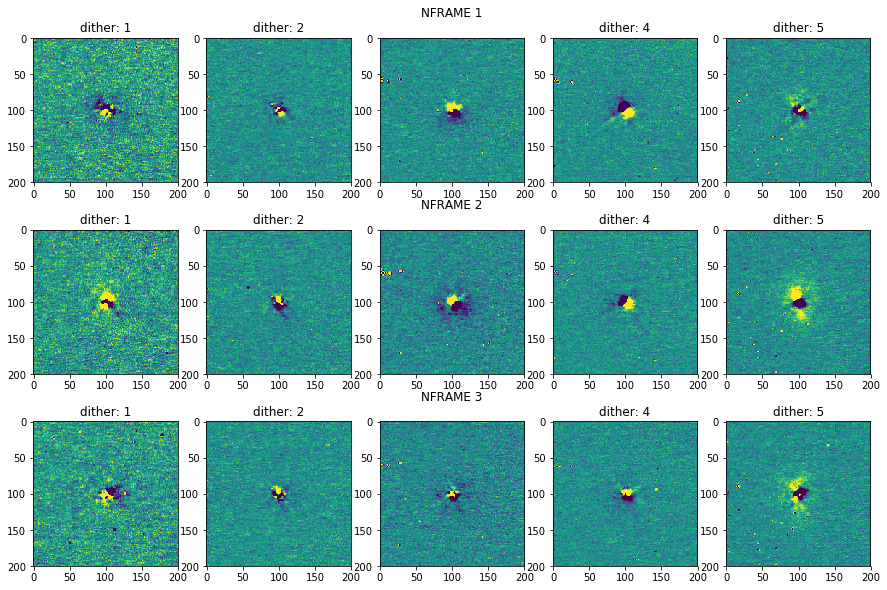

In [54]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for n,key in enumerate(Q1_shifted.keys()):
    vmin1, vmax1 = interval.get_limits(Q1_shifted[key])
    vmin2, vmax2 = interval.get_limits(Q2_shifted[key])
    vmin3, vmax3 = interval.get_limits(Q2_shifted[key])
    
    #Q1: nframe1
    ax[0,n].imshow(Q1_shifted[key], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Q2: nframe2
    ax[1,n].imshow(Q2_shifted[key], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Q3 nframe3
    ax[2,n].imshow(Q3_shifted[key], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## U

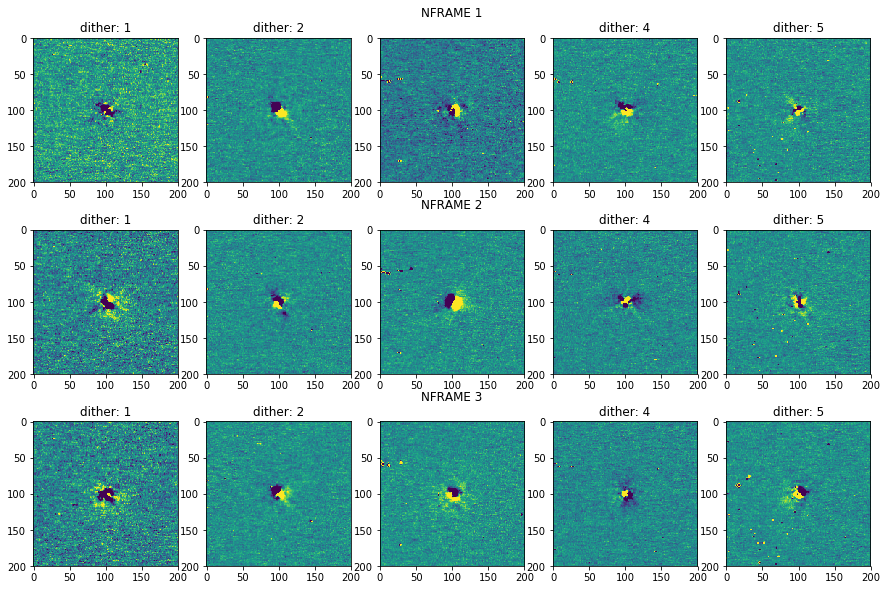

In [53]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for n,key in enumerate(U1_shifted.keys()):
    vmin1, vmax1 = interval.get_limits(U1_shifted[key])
    vmin2, vmax2 = interval.get_limits(U2_shifted[key])
    vmin3, vmax3 = interval.get_limits(U2_shifted[key])
    
    #Q1: nframe1
    ax[0,n].imshow(U1_shifted[key], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,n].set_title('dither: {}'.format(n+1))
    #Q2: nframe2
    ax[1,n].imshow(U2_shifted[key], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,n].set_title('dither: {}'.format(n+1))
    #Q3 nframe3
    ax[2,n].imshow(U3_shifted[key], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,n].set_title('dither: {}'.format(n+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## PI

In [51]:
PI3.keys()

[0, 1, 2, 3, 4]

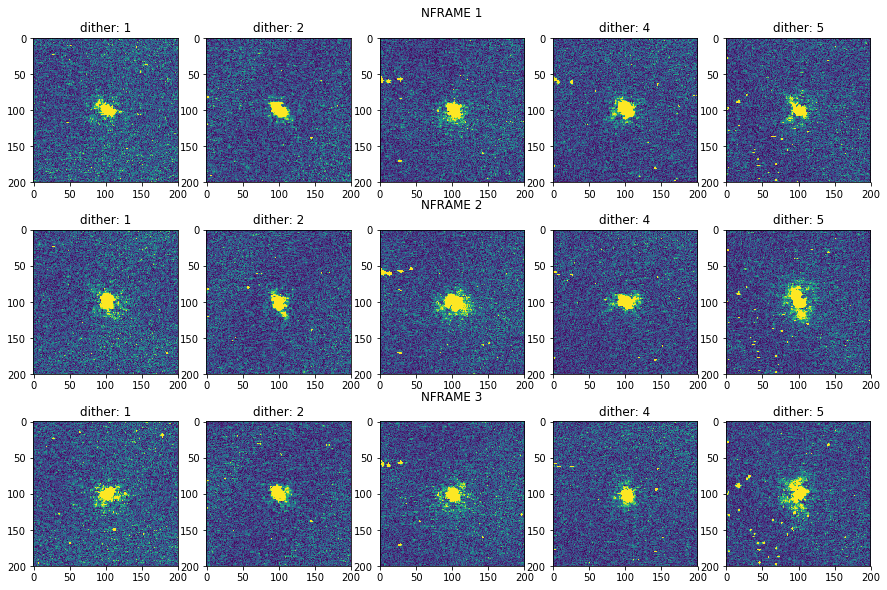

In [52]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))

for i in range(5):
    vmin1, vmax1 = interval.get_limits(PI1[i])
    vmin2, vmax2 = interval.get_limits(PI2[i])
    vmin3, vmax3 = interval.get_limits(PI3[i])
    
    ax[0,i].imshow(PI1[i], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[0,i].set_title('dither: {}'.format(i+1))
    ax[1,i].imshow(PI2[i], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[1,i].set_title('dither: {}'.format(i+1))
    ax[2,i].imshow(PI3[i], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[2,i].set_title('dither: {}'.format(i+1))
    
ax[0,2].set_title("NFRAME 1\n")
ax[1,2].set_title("NFRAME 2\n")
ax[2,2].set_title("NFRAME 3\n")

## median combined I, Q, U, PI (per dither)

In [55]:
Itot_med = {}
for n,key in enumerate(Itot1.keys()):
    Itot_med[n] = []
    #dither 1
    Itot_med[n].append(Itot1[key])
    Itot_med[n].append(Itot2[key])
    Itot_med[n].append(Itot3[key])
    #stack
    Itot_med[n]=np.median(Itot_med[n],axis=0)

Q_med = {}
for n,key in enumerate(Q1_shifted.keys()):
    Q_med[n] = []
    #dither 1
    Q_med[n].append(Q1_shifted[key])
    Q_med[n].append(Q2_shifted[key])
    Q_med[n].append(Q3_shifted[key])
    #stack
    Q_med[n]=np.median(Q_med[n],axis=0)
    
U_med = {}
for n,key in enumerate(U1_shifted.keys()):
    U_med[n] = []
    #dither 1
    U_med[n].append(U1_shifted[key])
    U_med[n].append(U2_shifted[key])
    U_med[n].append(U3_shifted[key])
    #stack
    U_med[n]=np.median(U_med[n],axis=0)
    
PI_med = {}
for n,key in enumerate(PI1.keys()):
    PI_med[n] = []
    #dither 1
    PI_med[n].append(PI1[key])
    PI_med[n].append(PI2[key])
    PI_med[n].append(PI3[key])
    #stack
    PI_med[n]=np.median(PI_med[n],axis=0)

## Stacked I, Q,U, & PI per dither

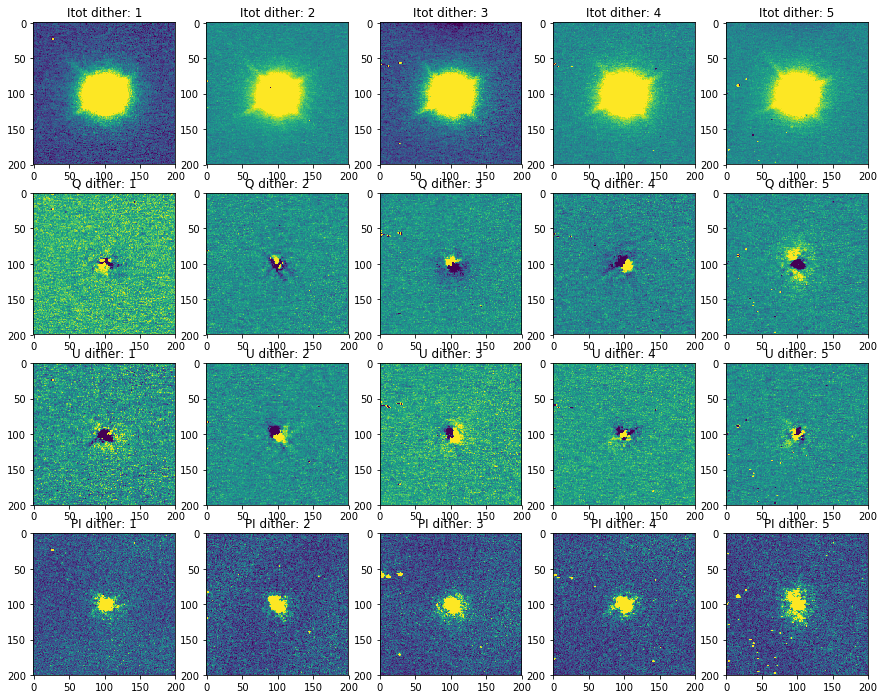

In [56]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,12))

for i in range(5):
    vmin0, vmax0 = interval.get_limits(Itot_med[i])
    vmin1, vmax1 = interval.get_limits(Q_med[i])
    vmin2, vmax2 = interval.get_limits(U_med[i])
    vmin3, vmax3 = interval.get_limits(PI_med[i])
    
    ax[0,i].imshow(Itot_med[i], vmin=vmin0, vmax=vmax0)#, cmap='gray')
    ax[0,i].set_title('Itot dither: {}'.format(i+1))
    ax[1,i].imshow(Q_med[i], vmin=vmin1, vmax=vmax1)#, cmap='gray')
    ax[1,i].set_title('Q dither: {}'.format(i+1))
    ax[2,i].imshow(U_med[i], vmin=vmin2, vmax=vmax2)#, cmap='gray')
    ax[2,i].set_title('U dither: {}'.format(i+1))
    ax[3,i].imshow(PI_med[i], vmin=vmin3, vmax=vmax3)#, cmap='gray')
    ax[3,i].set_title('PI dither: {}'.format(i+1))

## Combine dithered Itot, Q, U, PI

In [57]:
Itot_med_final = []
Q_med_final = []
U_med_final = []
PI_med_final = []

for i in range(5):
    #combine per dither
    Itot_med_final.append(Itot_med[i])
    Q_med_final.append(Q_med[i])
    U_med_final.append(U_med[i])
    PI_med_final.append(PI_med[i])

Itot_med_final = np.median(Itot_med_final, axis=0)
Q_med_final = np.median(Q_med_final, axis=0)
U_med_final = np.median(U_med_final, axis=0)
PI_med_final = np.median(PI_med_final, axis=0)

## previous results

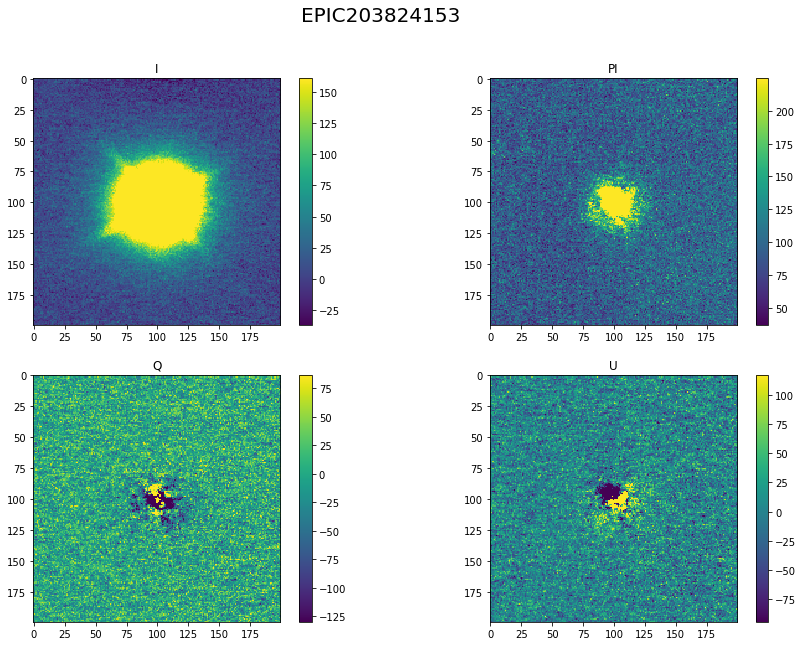

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

vmin0, vmax0 = interval.get_limits(Itot_med_final)
vmin1, vmax1 = interval.get_limits(PI_med_final)
#vmin1, vmax1 = interval.get_limits(PI_crop/I_crop)
vmin2, vmax2 = interval.get_limits(Q_med_final)
vmin3, vmax3 = interval.get_limits(U_med_final)

ax1 = ax[0,0].imshow(Itot_med_final, vmin=vmin0, vmax=vmax0)
ax[0,0].set_title('I')
fig.colorbar(ax1, ax=ax[0,0])#, orientation='horizontal')
#ax2 = ax[0,1].imshow(PI_crop/I_crop, vmin=vmin1, vmax=vmax1)
ax2 = ax[0,1].imshow(PI_med_final, vmin=vmin1, vmax=vmax1)
fig.colorbar(ax2, ax=ax[0,1])
#ax[0,1].set_title('PI/I')
ax[0,1].set_title('PI')
ax3 = ax[1,0].imshow(Q_med_final, vmin=vmin2, vmax=vmax2)
fig.colorbar(ax3, ax=ax[1,0])
ax[1,0].set_title('Q')
ax4 = ax[1,1].imshow(U_med_final, vmin=vmin3, vmax=vmax3)
fig.colorbar(ax4, ax=ax[1,1])
ax[1,1].set_title('U')
plt.suptitle(pf.getheader(skysub_ch1[0])['OBJECT'], fontsize=20)
#plt.tight_layout()
# ax[0,0].imshow(np.log(I_crop))
# ax[0,1].imshow(np.log(PI_crop))
# ax[1,0].imshow(np.log(Q_crop))
# ax[1,1].imshow(np.log(U_crop))

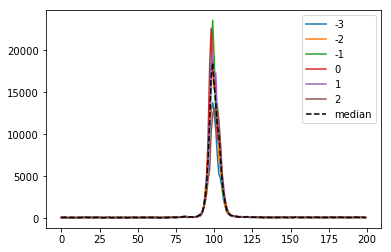

In [60]:
xslices=[]
for i in np.arange(-3,3,1):
    xslice=PI_med_final[PI_med_final.shape[1]/2+i,:]
    plt.plot(xslice, label=i)
    xslices.append(xslice)

xslice=np.median(xslices,axis=0)
plt.plot(xslice, 'k--', label='median')
plt.legend()

## estimating FWHM

A: 165.281441089
mu: 99.678595699
sigma= -3.05967719364
eps: 1.15824312542
est_fwhm= 7.20553979103


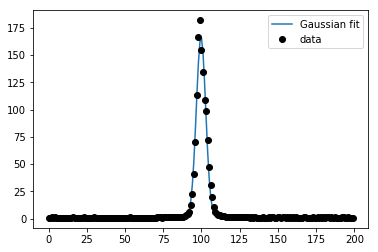

In [61]:
#using scipy
from scipy.optimize import curve_fit

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

#normalized
ydata = xslice/np.median(xslice)
xdata = np.array(range(len(ydata)))
xmean = len(xdata)/2
sigma = np.std(ydata)
#fitting
eps =0
popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [1, xmean, sigma, eps])

plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
plt.plot(xdata,ydata,'ok', label='data')
plt.legend()

est_fwhm=2.355*np.abs(popt[2])
print('A: {}\nmu: {}\nsigma= {}\neps: {}\nest_fwhm= {}'.format(popt[0],popt[1], popt[2], popt[3], est_fwhm))


## Polarization vectors

In [62]:
'''
pol vector class
'''

from scipy.ndimage.filters import gaussian_filter
from numpy import *
import matplotlib.pyplot as pl

max_length=10       # Pol=100 % in pixel

### Classes and Modules ###
class Linear_pol_vector:
    def __init__(self,x,y,I,Q,U,ax,max_length=10,linewidth=2,color='b'):
        self.x=x
        self.y=y
        self.I=I
        self.Q=Q
        self.U=U
        self.ax=ax
        self.max_length=max_length
        self.P=sqrt(Q**2+U**2)/I
        if self.P == 0:
            self.pl,=ax.plot([self.x,self.x],[self.y,self.y],linestyle='-',color=color,
                       linewidth=2)
        else:
            self.ang=arctan2(self.U,self.Q)*0.5
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl,=ax.plot([self.x-dx,self.x+dx],[self.y-dy,self.y+dy], linestyle='-',color=color,linewidth=2)
    def change_max_length(self,max_length=10):
        if self.P != 0:
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl.set_xdata=[self.x-dx,self.x+dx]
            self.pl.set_ydata=[self.y-dy,self.y+dy]
    def reset(self):
        self.change_max_length()
        self.pl.set_linewidth=2
        self.pl.set_color='w'

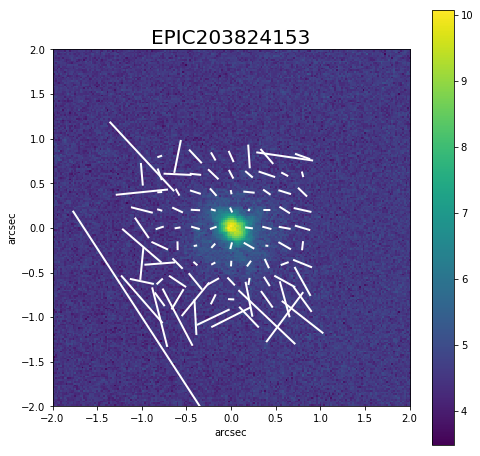

In [63]:
scale= 0.020 #ircs_pix_size: mas/pix
box_size = 200

#xcenter = int(sources['xcentroid'][2])
#ycenter = int(sources['ycentroid'][2])
xcenter = ycenter = box_size/2.0

#convert to AU by multiplying arsec with parsec
#x_in_AU=(np.arange(box_size)-xcenter)*scale*distance
#y_in_AU=(np.arange(box_size)-ycenter)*scale*distance

x_in_as=(np.arange(box_size)-xcenter)*scale
y_in_as=(np.arange(box_size)-ycenter)*scale

img_PI = PI_med_final
img_Q = Q_med_final
img_U = U_med_final
img_I = Itot_med_final



#shift reference w.r.t. the target coordinate
fig, ax = plt.subplots(1,1, figsize=(8,8))
a = 0-xcenter
b = box_size - xcenter
c = 0 -ycenter
d =  box_size - ycenter
extent_PI=np.array([a,b,c,d])*scale


#------------------PLOT image---------------------#
#normalize with I?
data = img_PI#/img_I
#vmin,vmax= interval.get_limits(data)
plt.imshow(np.log(data),extent=extent_PI)#, vmin=vmin,vmax=vmax)
plt.colorbar()

#------------------PLOT vectors---------------------#
#average of pol signal 
#varray=[]
dx=dy=1
area=(2*dx+1)*(2*dy+1)

#extent of the region where pol vectors will be drawn
dn = 50 #pix
xmin=xcenter-dn 
xmax=xcenter+dn
ymin=ycenter-dn
ymax=ycenter+dn
inc=10
for x in np.arange(xmin,xmax,inc):
    for y in np.arange(ymin,ymax,inc):
        x,y=int(x), int(y)
        if np.log(data[y,x]) < 9.0: #threshold of polarization (smaller is wider)
            I=sum(img_I[y-dy:y+dy+1,x-dx:x+dx+1])/area
            Q=sum(img_Q[y-dy:y+dy+1,x-dx:x+dx+1])/area
            U=sum(img_U[y-dy:y+dy+1,x-dx:x+dx+1])/area
            v=Linear_pol_vector(x_in_as[x],y_in_as[y],I,-Q,-U,ax,max_length=1,color='w')
#savefig('obj_PI_conva_sigma05_pol.fits',v???)
plt.draw()
#arcsec
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.title(pf.getheader(skysub_ch1[0])['OBJECT'], fontsize=20)
plt.show()